# Analysis of EBA Transparency Exercise Datasets

## Introduction

This notebook explores the datasets provided by the European Banking Authority (EBA) under their EU-wide Transparency Exercise, accessible [here](https://www.eba.europa.eu/risk-analysis-and-data/eu-wide-transparency-exercise). These datasets offer a comprehensive view of the banking sector's assets and risks, which is invaluable for financial analysis and regulatory assessment.

### Notes

- **Understand the Structure**: We will examine the structure and content of the EBA's credit risk dataset to understand the type of data provided and its potential applications.
- **Ensure Data Integrity**: Although these datasets are generally user-friendly, they require additional checks to validate data integrity and reliability. You should compare a sample of your intermediary results with the results presented by the EBA's interactive tool, specifically the visualizations found [here](https://tools.eba.europa.eu/interactive-tools/2023/powerbi/837203/tr23_visualisation_page5.html), to confirm consistency and understand any discrepancies.
- **Download the credit risk datasets from here**: https://www.eba.europa.eu/assets/TE2023/Full_database/837203/tr_cre.csv

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:,.2f}'.format

#### A. Create base table

In [66]:
# Import mappning tables
exposures = pd.read_excel('metadata_tr_2023.xlsx', sheet_name='Exposures')
portfolio = pd.read_excel('metadata_tr_2023.xlsx', sheet_name='Portfolio')
fin_instrument = pd.read_excel('metadata_tr_2023.xlsx', sheet_name='Financial_Instruments')
assets_stages = pd.read_excel('metadata_tr_2023.xlsx', sheet_name='ASSETS_Stages')
assets_fv = pd.read_excel('metadata_tr_2023.xlsx', sheet_name='ASSETS_FV')
institutions = pd.read_excel('metadata_tr_2023.xlsx', sheet_name='List of institutions')

# import core dataset
df = pd.read_csv('tr_oth_2023.csv', low_memory=False)

In [67]:
# Create final dataset
result = pd.merge(df, exposures, on='Exposure', how='left')
result = pd.merge(result, fin_instrument, on='Financial_instruments', how='left')
result = pd.merge(result, assets_stages, on='ASSETS_Stages', how='left')
result = pd.merge(result, assets_fv, on='ASSETS_FV', how='left')
result = pd.merge(result, institutions, on='LEI_Code', how='left')

result.head()

,LEI_Code,NSA,Period,Item,Label,ASSETS_FV,ASSETS_Stages,Exposure,Financial_instruments,Amount,Fin_end_year,n_quarters,Footnote,Row,Column,Sheet,exposure_label,Financial_instruments_label,ASSETS_Stages_label,ASSETS_FV_label,institution_country,Desc_country,Name,Finrep,Fin_year_end
0,0W2PZJM8XOY22M4GG883,DE,202209,2321001,"Cash, cash balances at central banks and other demand deposits",0,0,0,0,"22,438.22",0,3,NaN,10,5,Assets,Total / No breakdown,Total / No breakdown,No breakdown by ASSETS_Stages,No breakdown by ASSETS_FV,DE,Germany,DekaBank Deutsche Girozentrale,Yes - IFRS,31/12
1,0W2PZJM8XOY22M4GG883,DE,202209,2321002,Financial assets held for trading,0,0,0,0,"16,279.12",0,3,NaN,11,5,Assets,Total / No breakdown,Total / No breakdown,No breakdown by ASSETS_Stages,No breakdown by ASSETS_FV,DE,Germany,DekaBank Deutsche Girozentrale,Yes - IFRS,31/12
2,0W2PZJM8XOY22M4GG883,DE,202209,2321002,Financial assets held for trading,1,0,0,0,"3,956.74",0,3,NaN,11,6,Assets,Total / No breakdown,Total / No breakdown,No breakdown by ASSETS_Stages,Fair value hierarchy: Level 1,DE,Germany,DekaBank Deutsche Girozentrale,Yes - IFRS,31/12
3,0W2PZJM8XOY22M4GG883,DE,202209,2321002,Financial assets held for trading,2,0,0,0,"11,736.86",0,3,NaN,11,7,Assets,Total / No breakdown,Total / No breakdown,No breakdown by ASSETS_Stages,Fair value hierarchy: Level 2,DE,Germany,DekaBank Deutsche Girozentrale,Yes - IFRS,31/12
4,0W2PZJM8XOY22M4GG883,DE,202209,2321002,Financial assets held for trading,3,0,0,0,585.52,0,3,NaN,11,8,Assets,Total / No breakdown,Total / No breakdown,No breakdown by ASSETS_Stages,Fair value hierarchy: Level 3,DE,Germany,DekaBank Deutsche Girozentrale,Yes - IFRS,31/12


In [68]:
result['Label'].unique()

array(['Cash, cash balances at central banks and other demand deposits',
       'Financial assets held for trading',
       'Non-trading financial assets mandatorily at fair value through profit or loss',
       'Financial assets designated at fair value through profit or loss',
       'Financial assets at fair value through other comprehensive income',
       'Financial assets at amortised cost',
       'Derivatives – Hedge accounting',
       'Fair value changes of the hedged items in portfolio hedge of interest rate risk',
       'Other assets', 'Total Assets',
       'Gross carrying amount: Financial assets at fair value through other comprehensive income, Debt securities',
       'Gross carrying amount: Financial assets at fair value through other comprehensive income, Loans and advances',
       'Gross carrying amount: Financial assets at amortised cost, Debt securities',
       'Gross carrying amount: Financial assets at amortised cost, Loans and advances',
       'Accumulated i

### B. Compare stage 2 to stage 3

In [69]:
# Create base table
idx_1 = result['Label'].isin(['Accumulated impairment: Financial assets at amortised cost, Loans and advances'])
idx_2 = result['Period'] == 202306

pivot_df = pd.pivot_table(result[idx_1 & idx_2], 
                          values='Amount', 
                          index=['Name'], 
                          columns=['ASSETS_Stages'], 
                          aggfunc="sum", 
                          margins=True,
                          fill_value=0).reset_index()

pivot_df.sort_values(by=pivot_df.columns[-1], ascending=True).head(40)

ASSETS_Stages,Name,1,2,3,All
112,All,"-31,895.95","-54,005.76","-148,668.11","-234,569.82"
21,"Banco Santander, S.A.","-3,941.48","-5,224.76","-14,130.64","-23,296.88"
53,Groupe Crédit Agricole,"-2,986.88","-5,806.15","-12,265.42","-21,058.45"
15,BNP Paribas,"-2,050.02","-2,476.04","-13,272.16","-17,798.22"
52,Groupe BPCE,"-1,310.86","-3,993.91","-8,717.38","-14,022.15"
39,Confédération Nationale du Crédit Mutuel,"-1,920.20","-2,124.87","-7,309.19","-11,354.26"
19,"Banco Bilbao Vizcaya Argentaria, S.A.","-2,143.18","-2,021.14","-7,106.52","-11,270.84"
106,"UNICREDIT, SOCIETA' PER AZIONI","-1,396.87","-3,856.85","-5,792.77","-11,046.49"
99,Société générale S.A.,"-1,052.14","-2,036.60","-7,578.85","-10,667.59"
61,Intesa Sanpaolo S.p.A.,-780.01,"-1,671.22","-4,973.36","-7,424.59"


In [147]:

pd.set_option('display.max_rows', None)

# Create base table
idx_1 = result['Label'].isin(['Gross carrying amount: Financial assets at amortised cost, Loans and advances'])
idx_2 = result['Period'] == 202306

pivot_df = pd.pivot_table(result[idx_1 & idx_2], 
                          values='Amount', 
                          index=['Name', 'NSA'], 
                          columns=['ASSETS_Stages'], 
                          aggfunc="sum", 
                          margins=True,
                          fill_value=0).reset_index()

pivot_df.columns = pivot_df.columns.astype(str)
pivot_df['Stage_1_vs_Stage_2'] = pivot_df['2'] / pivot_df['1']

pivot_df = pivot_df.sort_values(by='All', ascending=False)

pivot_df

ASSETS_Stages,Name,NSA,1,2,3,All,Stage_1_vs_Stage_2
112,All,,"13,788,690.65","1,411,158.98","333,903.79","15,533,753.42",0.10
53,Groupe Crédit Agricole,FR,"1,138,802.13","111,480.18","25,153.91","1,275,436.22",0.10
21,"Banco Santander, S.A.",ES,"1,009,877.95","72,759.93","33,575.03","1,116,212.91",0.07
52,Groupe BPCE,FR,"795,888.56","126,951.26","21,024.95","943,864.78",0.16
15,BNP Paribas,FR,"831,092.50","70,675.02","25,926.28","927,693.80",0.09
39,Confédération Nationale du Crédit Mutuel,FR,"645,056.14","40,543.74","15,388.53","700,988.41",0.06
59,ING Groep N.V.,NL,"621,071.11","49,906.81","10,648.75","681,626.67",0.08
42,DEUTSCHE BANK AKTIENGESELLSCHAFT,DE,"530,274.20","52,086.53","12,146.44","594,507.18",0.10
99,Société générale S.A.,FR,"491,919.26","36,930.96","16,436.19","545,286.41",0.08
106,"UNICREDIT, SOCIETA' PER AZIONI",IT,"410,441.67","79,767.72","12,163.08","502,372.48",0.19


In [71]:
len(pivot_df)

113

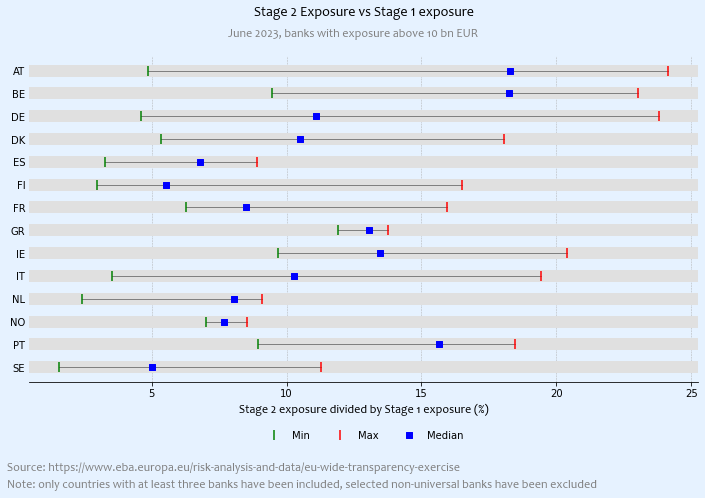

In [185]:
# Calculate statistics
# Remove the outlier
df_prov = pivot_df[(pivot_df['Stage_1_vs_Stage_2'] < 1) & (pivot_df['NSA'].str.len() > 0) & (pivot_df['All'] > 10_000) & (pivot_df['Stage_1_vs_Stage_2'] > 0) & (pivot_df['Stage_1_vs_Stage_2'] < 0.35)] .copy()
df_prov = df_prov.groupby('NSA').filter(lambda x: len(x) >= 3)
df_prov['Stage_1_vs_Stage_2'] = df_prov['Stage_1_vs_Stage_2'] * 100

stats = df_prov.groupby('NSA')['Stage_1_vs_Stage_2'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Calculate statistics
stats = df_prov.groupby('NSA')['Stage_1_vs_Stage_2'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#e6f2ff')  # Set background color of the figure
ax.set_facecolor('#e6f2ff')  # Set background color of the plot

# Define the positions for each country on the y-axis
positions = range(len(stats))

# Colors for each statistic
mean_color = 'orange'
median_color = 'blue'
min_color = 'green'
max_color = 'red'

# # Plot each statistic with lines connecting them
# for pos, country in zip(positions, stats['NSA']):
#     country_stats = stats[stats['NSA'] == country][['min', 'median', 'mean', 'max']].values.flatten()
#     ax.plot(country_stats, [pos, pos, pos, pos], color='grey', linestyle='-', linewidth=1)
#     ax.scatter(country_stats[2], pos, color=mean_color, marker='s', s=20, label='Mean' if pos == 0 else "")
#     ax.scatter(country_stats[1], pos, color=median_color, marker='s', s=20, label='Median' if pos == 0 else "")
#     ax.scatter(country_stats[0], pos, color=min_color, marker='s', s=20, label='Min' if pos == 0 else "")
#     ax.scatter(country_stats[3], pos, color=max_color, marker='s', s=20, label='Max' if pos == 0 else "")

# Plot each statistic with lines connecting them
for pos, country in zip(positions, stats['NSA']):
    country_stats = stats[stats['NSA'] == country][['min', 'median', 'mean', 'max']].values.flatten()
    ax.plot(country_stats, [pos, pos, pos, pos], color='grey', linestyle='-', linewidth=1)

# Plot the markers after the lines
for pos, country in zip(positions, stats['NSA']):
    country_stats = stats[stats['NSA'] == country][['min', 'median', 'mean', 'max']].values.flatten()
    
    # ax.scatter(country_stats[1], pos, color=median_color, marker='s', s=20, label='Median' if pos == 0 else "", zorder=2)
    ax.scatter(country_stats[0], pos, color=min_color, marker="|", s=100, label='Min' if pos == 0 else "", zorder=2)
    ax.scatter(country_stats[3], pos, color=max_color, marker="|", s=100, label='Max' if pos == 0 else "", zorder=2)
    # ax.scatter(country_stats[2], pos, color=mean_color, marker='s', s=40, label='Mean' if pos == 0 else "", zorder=2)
    ax.scatter(country_stats[1], pos, color=median_color, marker='s', s=40, label='Median' if pos == 0 else "", zorder=2)



# Customize the plot to mimic Economist style
ax.set_yticks(positions)
ax.set_yticklabels(stats['NSA'])
ax.invert_yaxis()  # Countries on the y-axis
ax.set_xlabel('Stage 2 exposure divided by Stage 1 exposure (%)', fontname='Candara', fontsize=12)
ax.set_title('Stage 2 Exposure vs Stage 1 exposure', pad=40, fontname='Candara', fontsize=14)
fig.text(0.5, 0.925, 'June 2023, banks with exposure above 10 bn EUR', ha='center', fontsize=12, color='grey', fontname='Candara')


# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, facecolor='#e6f2ff') #, facecolor=color, edgecolor=color, fontsize=12)
legend.get_frame().set_linewidth(0)  # Remove the border of the legend

# Economist style adjustments
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.grid(True, which='major', linestyle='--', linewidth=0.5)
# ax.yaxis.grid(False)
ax.yaxis.grid(True, color='#e0e0e0', linewidth=12)

# Remove y-axis ticks while keeping the labels
ax.tick_params(axis='y', which='both', length=0)

fig.text(0.1, -0.08, 'Source: https://www.eba.europa.eu/risk-analysis-and-data/eu-wide-transparency-exercise', ha='left', fontsize=12, color='grey', fontname='Candara')
fig.text(0.1, -0.12, 'Note: only countries with at least three banks have been included, selected non-universal banks have been excluded', ha='left', fontsize=12, color='grey', fontname='Candara')


plt.show()

In [72]:
xxx

NameError: name 'xxx' is not defined

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Sample DataFrame
data = {
    'NSA': ['Country A', 'Country B', 'Country A', 'Country B', 'Country A', 'Country B', 'Country A', ''],
    'Stage_1_vs_Stage_2': [0.3, 0.2, 0.45, 0.25, 0.55, 0.35, 0.8, 0.1]  # 0.8 is an outlier
}
df = pd.DataFrame(data)

# Filter out rows where 'NSA' contains at least one letter
df = df[df['NSA'].str.len() > 0]

# Remove the outlier
df_prov = df[df['Stage_1_vs_Stage_2'] < 1]

# Calculate statistics
stats = df_prov.groupby('NSA')['Stage_1_vs_Stage_2'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')  # Set background color of the figure
ax.set_facecolor('#f0f0f0')  # Set background color of the plot to a lighter grey

# Define the positions for each country on the y-axis
positions = range(len(stats))

# Colors for each statistic
mean_color = 'blue'
median_color = 'orange'
min_color = 'green'
max_color = 'red'

# Plot each statistic with lines connecting them
for pos, country in zip(positions, stats['NSA']):
    country_stats = stats[stats['NSA'] == country][['min', 'median', 'mean', 'max']].values.flatten()
    ax.plot(country_stats, [pos, pos, pos, pos], color='grey', linestyle='-', linewidth=1, zorder=1)

# Function to add a rectangle marker
def add_rectangle(x, y, color, ax):
    rect = Rectangle((x - 0.02, y - 0.1), 0.04, 0.2, linewidth=0, edgecolor=color, facecolor=color, zorder=2)
    ax.add_patch(rect)

# Plot the markers after the lines with higher zorder
for pos, country in zip(positions, stats['NSA']):
    country_stats = stats[stats['NSA'] == country][['min', 'median', 'mean', 'max']].values.flatten()
    add_rectangle(country_stats[2], pos, mean_color, ax)
    add_rectangle(country_stats[1], pos, median_color, ax)
    add_rectangle(country_stats[0], pos, min_color, ax)
    add_rectangle(country_stats[3], pos, max_color, ax)

# Customize the plot to mimic Economist style
ax.set_yticks(positions)
ax.set_yticklabels(stats['NSA'])
ax.invert_yaxis()  # Countries on the y-axis
ax.set_xlabel('Percent')
ax.set_title('Percent Statistics per Country', pad=20)  # Add space between title and graph

# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = ax.legend([Rectangle((0, 0), 1, 1, color=mean_color), Rectangle((0, 0), 1, 1, color=median_color),
                    Rectangle((0, 0), 1, 1, color=min_color), Rectangle((0, 0), 1, 1, color=max_color)],
                   ['Mean', 'Median', 'Min', 'Max'],
                   loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=4)
legend.get_frame().set_linewidth(0)  # Remove the border of the legend

# Economist style adjustments
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.grid(True, which='major


SyntaxError: EOL while scanning string literal (2168457327.py, line 74)